<center>

# Football Analytics

Neste notebook iremos explorar dados gratuitos disponibilizados pelo StatsBomb para análise de condução de bola. 

## IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

In [1]:
# Importando Bibliotecas necessárias
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from urllib.request import urlopen
from mplsoccer import Sbopen, Pitch, FontManager, VerticalPitch, add_image
from PIL import Image
from statsbombpy import sb

In [2]:
competitions = sb.competitions()

In [3]:
# Criando uma lista com todas competições e seus respectivos ids, ordenadas de forma alfabética
competitions_list = competitions[['competition_name', 'competition_id']].drop_duplicates().reset_index(drop=True)
competitions_list

,competition_name,competition_id
0,1. Bundesliga,9
1,African Cup of Nations,1267
2,Champions League,16
3,Copa America,223
4,Copa del Rey,87
5,FA Women's Super League,37
6,FIFA U20 World Cup,1470
7,FIFA World Cup,43
8,Indian Super league,1238
9,La Liga,11


In [4]:
# Criando uma lista com todas as temporadas listadas da mais recente para a mais antiga
seasons_list = competitions[['season_name', 'season_id']].sort_values(by='season_name', ascending=False).drop_duplicates().reset_index(drop=True)
seasons_list.set_index('season_name').head(10)

,season_id
season_name,
2024,282
2023/2024,281
2023,107
2022/2023,235
2022,106
2021/2022,108
2020/2021,90
2020,43
2019/2020,42


# SELECIONANDO COMPETIÇÃO E TEMPORADA

In [5]:
df_championship = sb.matches(competition_id=43 , season_id=106 )

In [6]:
# Checando as equipes que disputaram a competição
df_championship['home_team'].sort_values().unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

In [7]:
def data(team):
    
    df_team = df_championship.loc[(df_championship['home_team'] == f'{team}')|(df_championship['away_team'] == f'{team}')]
    match_list = df_team['match_id'].unique().tolist()
        
    # Inicializar o parser
    parser = Sbopen()

    # Listas para armazenar os dataframes
    all_df = []
    all_related = []
    all_freeze = []
    all_tactics = []

    # Iterar sobre cada ID de jogo e coletar os dados
    for id in match_list:
        df, related, freeze, tactics = parser.event(id)
            
        # Adicionar os dataframes coletados às listas correspondentes
        all_df.append(df)
        all_related.append(related)
        all_freeze.append(freeze)
        all_tactics.append(tactics)

    df_combined = pd.concat(all_df, ignore_index=True) # Informações de eventos detalhados
    related_combined = pd.concat(all_related, ignore_index=True) # Informação de eventos relacionados (ex: Pass - Ball Receipt)
    freeze_combined = pd.concat(all_freeze, ignore_index=True) # Informações de coordenada dos eventos
    tactics_combined = pd.concat(all_tactics, ignore_index=True) # informações dos jogadores(nº camisa, posição, nome e ID)
    
    return df_combined, related_combined, freeze_combined, tactics_combined, df_team

## SELECIONANDO EQUIPE

In [8]:
# Escolha a equipe que deseja analisar e substitua na variável 'team'
team = 'Brazil'
df_combined, related_combined, freeze_combined, tactics_combined, df_team = data(team=team)

In [9]:
# Extraindo os nomes completos dos jogadores da equipe selecionada anteriormente
df_players = df_combined[df_combined['team_name'] == team]
players_names = df_players['player_name'].sort_values().unique().tolist()
players_names

['Alex Nicolao Telles',
 'Alex Sandro Lobo Silva',
 'Alisson Ramsés Becker',
 'Antony Matheus dos Santos',
 'Bruno Guimarães Rodriguez Moura',
 'Carlos Henrique Casimiro',
 'Daniel Alves da Silva',
 'Danilo Luiz da Silva',
 'Ederson Santana de Moraes',
 'Frederico Rodrigues Santos',
 'Fábio Henrique Tavares',
 'Gabriel Fernando de Jesus',
 'Gabriel Teodoro Martinelli Silva',
 'Gleison Bremer Silva Nascimento',
 'Lucas Tolentino Coelho de Lima',
 'Marcos Aoás Corrêa',
 'Neymar da Silva Santos Junior',
 'Pedro Guilherme Abreu dos Santos',
 'Raphael Dias Belloli',
 'Richarlison de Andrade',
 'Rodrygo Silva de Goes',
 'Thiago Emiliano da Silva',
 'Vinícius José Paixão de Oliveira Júnior',
 'Weverton Pereira da Silva',
 'Éder Gabriel Militão',
 'Éverton Augusto de Barros Ribeiro',
 nan]

In [10]:
# Extraindo a fração para facilitar a visualização do id do jogo para seleção
team_match_ids = df_team['match_id'].unique().tolist()
df_team[df_team['match_id'].isin(team_match_ids)][['match_id', 'home_team', 'away_team']]

,match_id,home_team,away_team
3,3857258,Brazil,Serbia
14,3857269,Brazil,Switzerland
22,3869420,Croatia,Brazil
25,3869253,Brazil,South Korea
48,3857280,Cameroon,Brazil


In [13]:
def carry_analysis(player=None, match=None):
    
    df_carry = df_combined[df_combined['type_name'] == 'Carry']
    df_carry = df_carry[df_carry['team_name'] == team]

    # Filtra as conduções de acordo com o jogo (se fornecido)
    if match is not None:
        df_pass_filtered_match = df_carry[df_carry.match_id == match]
    else:
        df_pass_filtered_match = df_carry[df_carry.match_id.isin(team_match_ids)]  # Todos os jogos da equipe

    # Filtra as conduções de acordo com o jogador (se fornecido)
    if player is not None:
        df_pass_filtered_player = df_pass_filtered_match[df_pass_filtered_match.player_name == player].reset_index(drop=True)
    else:
        df_pass_filtered_player = df_pass_filtered_match.reset_index(drop=True)  # Todos os jogadores

    # Plotar apenas se houver dados
    if df_pass_filtered_player.empty:
        print("Nenhuma condução encontrada para os filtros aplicados.")
        return

    
    start_x = df_pass_filtered_player.x
    start_y = df_pass_filtered_player.y
    end_x = df_pass_filtered_player.end_x
    end_y = df_pass_filtered_player.end_y
    
    # Condições
    condução_ofensiva = (end_x >= start_x + 5)
    condução_lateral = (end_x < start_x + 5) & (end_x > start_x - 5)
    condução_defensiva = (end_x < start_x - 5)
    
    
    # Definindo cores para conduções
    cores = []
    for i in range(len(start_x)):
        if condução_ofensiva[i]:
            cores.append('#008000')  # Verde 
        elif condução_lateral[i]:
            cores.append('#FFD700')  # Dourado 
        elif condução_defensiva[i]:
            cores.append('#800080')  # Roxo 
        else:
            cores.append('#FFA500')  # Laranja para outros
    
    
    # Campo
    pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(10, 6))
    
    
    # Plotando as marcações
    for i in range(len(start_x)):
        pitch.lines(start_x[i], start_y[i], end_x[i], end_y[i], ax=ax, color=cores[i], comet=True)
    
    
    # Adicionando a legenda das cores
    legend_colors = [
        mpatches.Patch(color='#008000', label='Offensive Carry'),
        mpatches.Patch(color='#FFD700', label='Lateral Carry'),
        mpatches.Patch(color='#800080', label='Defensive Carry')]
    
    legend = ax.legend(handles=legend_colors, loc='upper right', bbox_to_anchor=(1.22, 1), title="Carry Types", title_fontsize=14, fontsize=10)
    
    
    # Título com base nas condições
    if match is not None:
        df_home_away = df_team[df_team['match_id'] == match]
        home = df_home_away['home_team'].iloc[0]
        away = df_home_away['away_team'].iloc[0]
        title_match_info = f"{home} Vs {away}"
    else:
        title_match_info = "Todos os jogos"

    if player is not None:
        title_player_info = f"{player}"
    else:
        title_player_info = f"{team}"

    plt.title(f'Análise de Conduções: {title_player_info} - {title_match_info} - {df_championship["competition"].loc[0]} {df_championship["season"].loc[0]}')
    plt.show()


## ANALISANDO

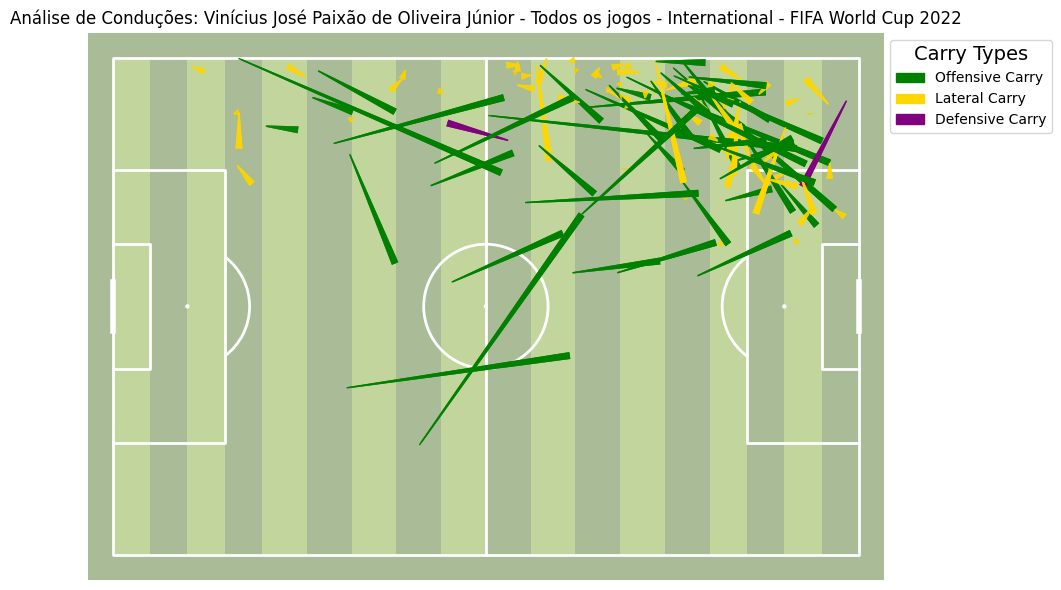

In [14]:
# Chamando a função para realizar a análise

# Para analisar todos os jogos da equipe na competição selecionada basta chamar a função sem nenhum argumento: carry_analysis()
# Para analisar um jogo específico da equipe selecionada: carry_analysis(match=match_id)
# Para analisar um jogador específico na competição inteira: carry_analysis(player='player_name')
# Para analisar um jogador específico em um jogo específico: carry_analysis(player='player_name', match=match_id)

carry_analysis(player='Vinícius José Paixão de Oliveira Júnior')